# imports

In [ ]:
import os
path = os.getcwd()

if path[1:5] == 'Home':
    %run /Home/siv30/wad005/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Home/siv30/wad005/master/GRB/src/dau_det_distribution.ipynb
    %run /Home/siv30/wad005/master/GRB/src/ASIMXspec.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Home/siv30/wad005/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb
    %run /Home/siv30/wad005/useful_py_functions/matplotlib_custom_style_and_macros.py
    mat_path = '/Home/siv30/wad005/master/GRB/MATLAB/andrey_mezentsev/'
else:
    %run /Users/andreas/phys/master/GRB/src/harvest_matlab_data.ipynb
    #%run /Users/andreas/phys/master/GRB/src/dau_det_distribution.ipynb
    %run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
    %run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb

    
from stingray import Lightcurve as LC
from stingray import CrossCorrelation as CC
import numpy as np
import matplotlib.pyplot as plt
import os, re, sys
from astropy.io import fits, ascii
from astropy.time import Time
import scipy.io
import pandas as pd

from gbm.data import TTE,RSP,Trigdat
from gbm.binning.unbinned import bin_by_time
from gbm.plot import Lightcurve, Spectrum
from gbm.background import BackgroundFitter
from gbm.background.binned import Polynomial #working in ctime for example

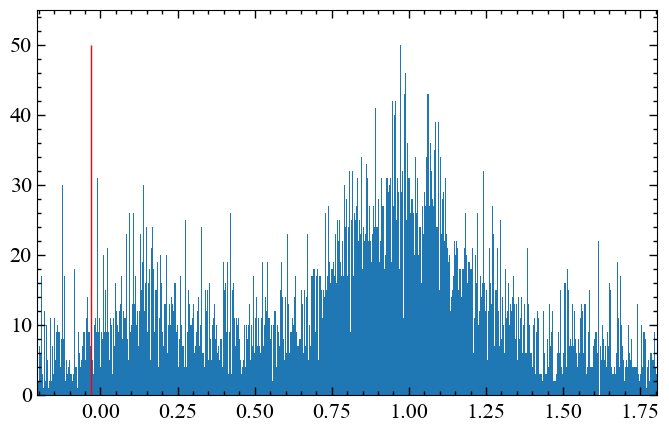

In [3]:
df_asim = pd.read_csv(mat_path_andrey+'GRB190305A.csv')
#working with [s]

tlagg = 0.5150625
df_asim['tus'] /= 1e6
df_asim['tus'] += tlagg
tus = df_asim['tus'].to_numpy(dtype=np.float64)
binsize = 0.002 #16ms
bins = np.arange(min(tus),max(tus)+binsize,binsize)
plt.hist(tus,bins=bins)
plt.vlines(x=-0.0293,ymin=0,ymax=50,color='r')


plt.show()

In [8]:
T0 = datetime.fromisoformat('2019-03-05T13:05:20.099945') + timedelta(seconds=tlagg)#cottected_datetime_level1
df_asim = make_adr(df_asim)
df_asim.sort_values(by=['adr','tus'],inplace=True,ignore_index=True)
df_asim.drop(df_asim[df_asim['typ']==3].index, inplace = True) #removed valleys
df_asim.head()

,tus,dau,det,typ,erg,adr
0,-0.205330,1,1,0,1768,1
1,-0.203277,1,1,0,66,1
2,-0.202303,1,1,0,1925,1
3,-0.201106,1,1,0,26,1
4,-0.196887,1,1,0,72,1


In [9]:
#converting to us
df_asim['tus'] *= 1e6
tus,erg,dau,det = df_asim['tus'].to_numpy(dtype=np.float64),df_asim['erg'].to_numpy(),df_asim['dau'].to_numpy(),df_asim['det'].to_numpy()
T0_GRB190606A = datetime.fromisoformat('2019-06-06T01:55:07.318605')
keV,abc = convert_erg(erg,dau,det,T0) #need to use different calibration coefs
print(abc)
df_asim['keV'] = keV


st,dt = get_st(df_asim),get_dt(df_asim) #st returned in us
df_asim['st']=st
df_asim['dt']=dt

flag = get_flag(df_asim)
df_asim['flag'] = flag
df_asim.drop(df_asim[get_flag(df_asim)].index,inplace=True)
df_asim.sort_values(by='tus',inplace=True,ignore_index=True)
df_asim['tus'] /= 1e6
print('Safety time: ',np.round((len(np.where(flag==True))/len(tus))*100,3), '% removed')
print('sorted by tus (s)')

[[5.013000e-03 7.932200e+00 5.414439e+01]
 [5.013000e-03 7.932200e+00 5.414439e+01]
 [5.013000e-03 7.932200e+00 5.414439e+01]
 ...
 [2.776000e-03 1.181790e+01 1.900340e+01]
 [2.776000e-03 1.181790e+01 1.900340e+01]
 [2.776000e-03 1.181790e+01 1.900340e+01]]
Safety time:  0.007 % removed
sorted by tus (s)


# CC

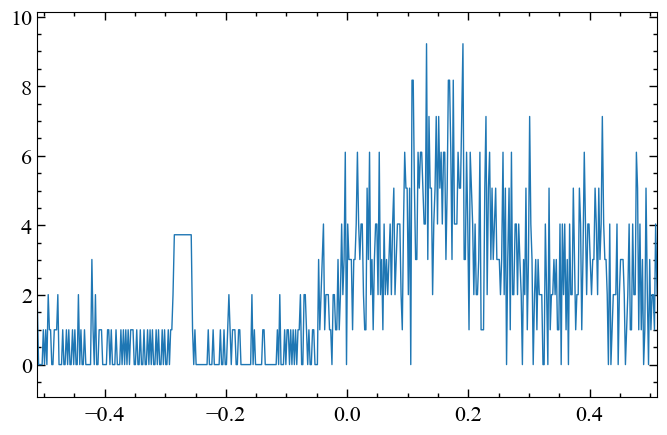

In [11]:
kw_filename = "GRB190305A_2ms.txt"
kw_file = kw_lc_path + kw_filename
binsize=0.002

kw_df = pd.read_csv(kw_file,sep='\s+')
kw_bin_lo,kw_bin_hi,G1,G2,G3= kw_df["Ti"].to_numpy(dtype=np.float16), kw_df["Tf"].to_numpy(dtype=np.float16),kw_df["G1"].to_numpy(dtype=np.float16), kw_df["G2"].to_numpy(dtype=np.float16), kw_df["G3"].to_numpy(dtype=np.float16)

kw_dt = np.round(np.diff(kw_bin_lo),3)
i_stop_kw = np.where(kw_dt>2*binsize)[0][0]



kw_bin_lo, kw_bin_hi, G1, G2, G3 = kw_bin_lo[:i_stop_kw], kw_bin_hi[:i_stop_kw], G1[:i_stop_kw],G2[:i_stop_kw], G3[:i_stop_kw]
kwCounts = G3

bins = np.append(kw_bin_lo,kw_bin_hi[-1]) #standard bins

kw_lc = LC(time=np.round(kw_bin_lo + binsize/2,3), counts=kwCounts, skip_checks=True,dt=binsize)
kw_lc.plot()

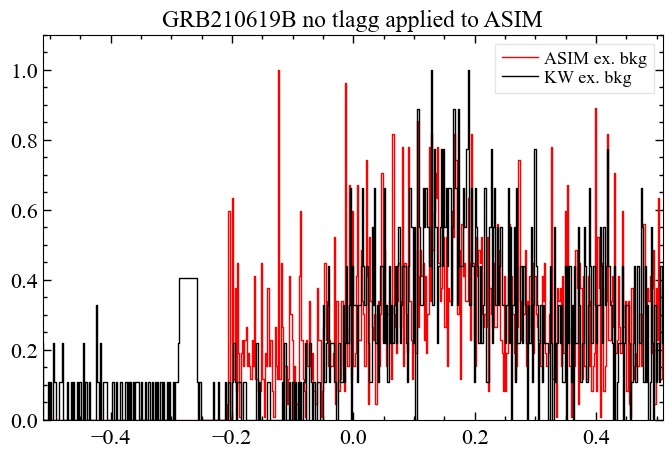

In [12]:
tus_asim = df_asim['tus'].to_numpy()

asim_counts, asim_edges = np.histogram(tus_asim, bins=bins)
j_a_stop = np.searchsorted(asim_edges,-0.1054)
asim_counts = np.maximum(asim_counts - np.mean(asim_counts[:j_a_stop]), 0) #removing bkg from ASIM

plt.step(x=asim_edges[:-1], y=asim_counts/max(asim_counts), where='pre', label='ASIM ex. bkg',c='r')
plt.step(x=bins[:-1],y=G3/max(G3),where='pre',label='KW ex. bkg',c='black')
#plt.vlines(x=[0.512,0.768],ymin=0,ymax=1.1,color='blue')
#plt.xlim(left=0.1, right=2)
plt.ylim(bottom=0)
plt.legend()
plt.title("GRB210619B no tlagg applied to ASIM")
plt.show() #evident that the asim lc must be shifted by ~ -0.6s

In [13]:
asim_lc = LC(time=asim_edges[:-1]+binsize/2,counts=asim_counts,skip_checks=True)
kw_lc = LC(time=bins[:-1]+binsize/2,counts=G3,skip_checks=True)
np.all(asim_lc.bin_lo == kw_lc.bin_lo)

True

tlagg_asim: 0.0


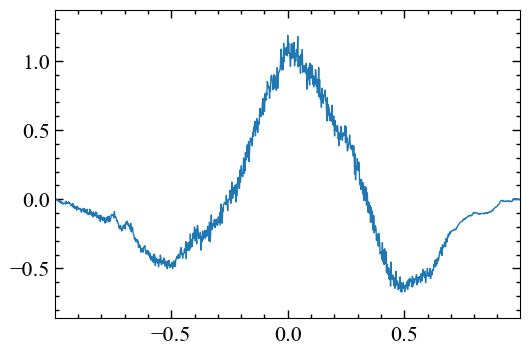

In [14]:
CC_kw_asim = CC(kw_lc,asim_lc,mode='full',norm='variance')
tlagg_asim = CC_kw_asim.time_shift
print(f'tlagg_asim: {tlagg_asim}')
CC_kw_asim.plot()
plt.show()

In [15]:
tlagg_final = tlagg + tlagg_asim
print(tlagg_final)

0.5150625


background accumulated up to -0.0293


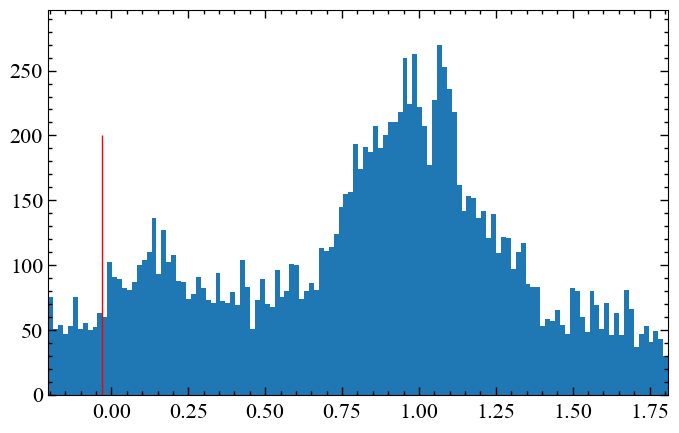

In [16]:
tus = df_asim['tus'].to_numpy()
binsize=0.016
bins = np.arange(min(tus),max(tus)+binsize,binsize)
plt.hist(tus,bins=bins)
plt.vlines(x=bins[11],ymin=0,ymax=200,color='r')
print(f'background accumulated up to {round(bins[11],4)}')
plt.show()

In [17]:
#need the df for bkg and burst

jx = np.searchsorted(tus,bins[11])
df_bkg = df_asim.truncate(after=jx)
df_burst = df_asim.truncate(before=jx+1)

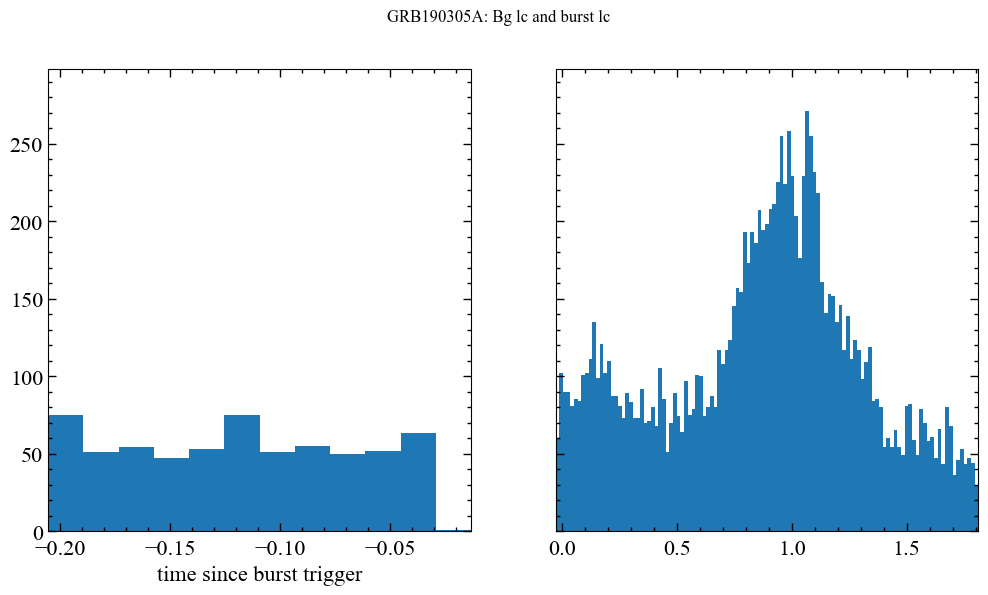

In [18]:
tus_bkg,tus_burst = df_bkg['tus'].to_numpy(),df_burst['tus'].to_numpy()

fig, (ax1, ax2) = plt.subplots(1, 2,sharey=True,figsize=(12, 6))
fig.suptitle('GRB190305A: Bg lc and burst lc')
ax1.hist(tus_bkg,bins=np.arange(min(tus_bkg),max(tus_bkg)+binsize,binsize))
ax2.hist(tus_burst,bins=np.arange(min(tus_burst),max(tus_burst)+binsize,binsize))
ax1.set_xlabel("time since burst trigger")
plt.show()

In [175]:
kev_arr = keV_hist(df=df_burst,time_interval=(0.768,1.280),keV_interval='max')

initial len: (12817, 12817)
Start/Stop (0.7682225, 1.2797825)
len kev 6098
len tus 6098
mean: 152.45
[   0    0    0    0    0    0    0    0    0    0    0    0    0  114
  477  973 1221  881  587  445  279  199  148   88   83   62   44   42
   24   25   26   19   28   40  187  100    6    0    0    0]


In [20]:
keV_bkg = keV_hist(df=df_bkg,time_interval=(-0.205330,-0.0293),keV_interval='max')

Energies binned!


# FITS

In [174]:
%run /Users/andreas/phys/master/GRB/src/ASIMXspec.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/BAK/ASIMbak.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/PHA/ASIMpha.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/ASIMrsp.ipynb
%run /Users/andreas/phys/master/GRB/xspec/ASIM/ASIMFits/RSP/find_closest_DRM.ipynb


All MAC paths are set!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


### PHA

In [176]:
bin_lo = keV_burst['bins_keV'].to_numpy()[:-1]
bin_hi = keV_burst['bins_keV'].to_numpy()[1:]
counts = keV_burst['counts'].to_numpy()[1:]
err = keV_burst['poisson_error_counts'].to_numpy()[1:]
print(len(bin_lo),len(bin_hi),len(counts),len(err))

tus_burst = df_burst['tus'].to_numpy(dtype=np.float64)
print('Exposure: ',
      np.round(tus_burst[np.searchsorted(tus_burst,1.280)]-
               tus_burst[np.searchsorted(tus_burst,0.768)],6))
print(T0)


40 40 40 40
Exposure:  0.511977
2019-03-05 13:05:20.615007


In [177]:
np.mean(counts)

152.45

In [23]:
PHA_dict = {
'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
'T0TIME':['2019-03-05T13:05:20.615','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
'TSTART': [0.768,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
'TSTOP': [1.280,'End time of spectrum accumulation'], #<float> [s]
'EXPOSURE': [0.512121,'[s] Integration time in seconds for the PHA data'], #<float> 
'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
'BACKFILE': ['HED_GRB190305A_new.bak','Background FITS file'], #<str> ('example.bak')
'RESPFILE': ['HED_GRB190305A_new.rsp','Response FITS file'], #<str> ('example.rsp')
'FILENAME': ['HED_GRB190305A_new.pha','PHA filename'] #<str>  ('example.pha')
}
generatePHA(PHA_dict=PHA_dict, counts=counts, stat_err=err, bin_lo=bin_lo, bin_hi=bin_hi)

### BAK

In [24]:
bin_lo = keV_bkg['bins_keV'].to_numpy()[:-1]
bin_hi = keV_bkg['bins_keV'].to_numpy()[1:]
counts_bkg = keV_bkg['counts'].to_numpy()[1:]
err_bkg = keV_bkg['poisson_error_counts'].to_numpy()[1:]
print(len(bin_lo),len(bin_hi),len(counts_bkg),len(err_bkg))

tus_bkg = df_bkg['tus'].to_numpy(dtype=np.float64)
print('Exposure: ',
      np.round(tus_bkg[np.searchsorted(tus_bkg,-0.0293)]-
               tus_bkg[np.searchsorted(tus_bkg,-0.205330)],6))
print(T0)

40 40 40 40
Exposure:  0.175191
2019-03-05 13:05:20.615007


In [25]:
bak_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.615','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [-0.205330,'[s] Start time of background accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [-0.0293,'End time of background accumulation'], #<float> [s]
    'EXPOSURE': [0.175191,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190305A_new.bak','Backgorund filename for fits file'] #<str>  ('example.bak')
}
generateBAK(BAK_dict=bak_dict,bin_lo=bin_lo,bin_hi=bin_hi,bakCounts=counts_bkg,stat_err=err_bkg)

### RSP

In [26]:
rsp_dict = {
    'USER': ['Andreas Ramsli','Username of creator of this fits file'], #<str>
    'T0TIME':['2019-03-05T13:05:20.615','Trigger time UT format=YYYY-MM-DDThh:mm:ss.fff'], #<str> 
    'TSTART': [0.768,'[s] Start time of spectrum accumulation'], #<float> [s] Start time of spectrum accumulation relative to T0TIME
    'TSTOP': [1.280,'End time of spectrum accumulation'], #<float> [s]
    'EXPOSURE': [0.512121,'[s] Integration time in seconds for the PHA data'], #<float> 
    'OBJECT': ['GRB190305A','Name of the observed object'], #<str> 
    'RA_OBJ': [340.399,'[deg] RA of source'], #<float> 
    'DEC_OBJ':  [-10.588,'[deg] Dec of source'], #<float>
    'FILENAME': ['HED_GRB190305A_new.rsp','RSP filename'] #<str>  ('example.pha')
}

theta,phi=133.904,-2.076

#drm_fn=find_DRM_file(dir_path='/Home/siv30/wad005/master/HED_DRM/data/',
#             theta=theta,phi=phi)

drm_fn = 'HED_drm_mats_135.00_0.00.txt'

generateRSP(RSP_dict=rsp_dict, 
            DRM_fname=drm_fn, 
            bin_lo=bin_lo,
            bin_hi=bin_hi,
            theta=theta,
            phi=phi)

# DEBUGG

In [27]:
#checking if count rate for burst is ~6k cts/s

In [178]:
df_burst = df_burst.sort_values(by='tus')
tus_burst=df_burst['tus'].to_numpy()
ii,jj = np.searchsorted(tus_burst,0.768),np.searchsorted(tus_burst,1.280)
tt = tus_burst[ii:jj]
tt

array([0.7682225, 0.7683135, 0.7684275, ..., 1.2786125, 1.2796475,
       1.2797825])

In [135]:
print(f'There are {round(len(tt)/(tt[-1]-tt[0]),1)} cts/s in raw data')

There are 11920.4 cts/s in raw data


In [180]:
kev = df_burst['keV'].to_numpy()
kev = kev[ii:jj]
print(len(kev))
bins_kev = np.round(np.append(np.logspace(1, 5, num=40, endpoint=False),1e5),5)

6098


In [181]:
kev.sort()
kev_arr.sort()
np.all(kev==kev_arr)

True

In [182]:
hist_keV, edges_keV = np.histogram(kev,bins=bins_kev)

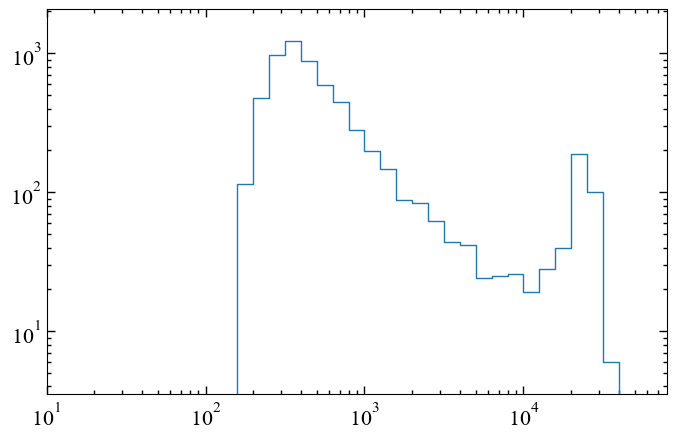

In [183]:
plt.step(edges_keV[:-1],hist_keV)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [184]:
np.mean(hist_keV),np.max(hist_keV)

(152.45, 1221)